<a href="https://colab.research.google.com/github/Mahbub511/IDAA-Research-Work/blob/main/IDAA_final_SHAP_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Required Libraries

In [ ]:
# Install required packages (only run once in Colab)
!pip install shap lime scikit-learn pandas matplotlib seaborn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Mount Google Drive and Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Core
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Explainable AI
import shap
import lime
import lime.lime_tabular

# Balance
from imblearn.over_sampling import SMOTE

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


Mounted at /content/drive


## **STEP 2: Load BRFSS and NHANES Data**
BRFSS: [click Here](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download)

---


NAHENS: [Click Here](https://www.kaggle.com/datasets/ramendrapandey/nhanes-2015-2016)

### Dataset Overview
We use two datasets:
1. **BRFSS 2015** – Contains behavioral and lifestyle indicators (self-reported survey data).
2. **NHANES 2015–2016** – Contains laboratory and physiological data (clinical data).

We will integrate these datasets to form a hybrid dataset for predicting multimorbidity.



In [ ]:
# Set paths from your Google Drive
brfss_path = '/content/drive/MyDrive/Summer25/Data Analytics/IDAA/diabetes_binary_health_indicators_BRFSS2015.csv'
nhanes_path = '/content/drive/MyDrive/Summer25/Data Analytics/IDAA/NHANES.csv'

brfss = pd.read_csv(brfss_path)
nhanes = pd.read_csv(nhanes_path)

# Drop duplicates and fill missing
brfss.drop_duplicates(inplace=True)
nhanes.drop_duplicates(inplace=True)

brfss.fillna(brfss.median(numeric_only=True), inplace=True)
nhanes.fillna(nhanes.median(numeric_only=True), inplace=True)

# Convert object/categorical to numeric
for col in nhanes.select_dtypes(include='object').columns:
    nhanes[col] = nhanes[col].astype('category').cat.codes


# **Merge Datasets into Hybrid Set**

In [ ]:
# Align sizes by sampling equal number of rows
min_len = min(len(brfss), len(nhanes))
brfss = brfss.sample(n=min_len, random_state=42).reset_index(drop=True)
nhanes = nhanes.sample(n=min_len, random_state=42).reset_index(drop=True)

# Drop duplicate target from NHANES if exists
if 'Diabetes_binary' in nhanes.columns:
    nhanes.drop(columns=['Diabetes_binary'], inplace=True)

# Concatenate horizontally (column-wise)
hybrid_df = pd.concat([brfss, nhanes], axis=1)
hybrid_df.shape


(5735, 50)

# **Preprocessing**
### Preprocessing Steps
- **Duplicates removed:** Ensures data integrity.
- **Missing values:** Filled using median values to avoid bias.
- **Categorical encoding:** Non-numeric columns are label encoded.
- **Dataset merging:** Both datasets are combined on their common columns to create a hybrid dataset.


In [ ]:
# Drop duplicates
brfss.drop_duplicates(inplace=True)
nhanes.drop_duplicates(inplace=True)

# Example handling of missing values
brfss.fillna(brfss.median(), inplace=True)
nhanes.fillna(nhanes.median(), inplace=True)

# If NHANES has non-numeric columns, encode them
for col in nhanes.select_dtypes(include=['object']).columns:
    nhanes[col] = nhanes[col].astype('category').cat.codes

# Align columns (we’ll just concatenate on common columns for simplicity)
common_cols = [col for col in brfss.columns if col in nhanes.columns]
hybrid_df = pd.concat([brfss[common_cols], nhanes[common_cols]], ignore_index=True)

print("Hybrid Dataset Shape:", hybrid_df.shape)
hybrid_df.head()


Hybrid Dataset Shape: (11470, 0)


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

In [ ]:
# Step 1: Drop duplicates and handle missing values
brfss.drop_duplicates(inplace=True)
nhanes.drop_duplicates(inplace=True)

brfss.fillna(brfss.median(numeric_only=True), inplace=True)
nhanes.fillna(nhanes.median(numeric_only=True), inplace=True)

# Step 2: Encode object columns in NHANES (if any)
for col in nhanes.select_dtypes(include='object').columns:
    nhanes[col] = nhanes[col].astype('category').cat.codes

# Step 3: Align the number of rows
min_len = min(len(brfss), len(nhanes))

brfss_aligned = brfss.sample(n=min_len, random_state=42).reset_index(drop=True)
nhanes_aligned = nhanes.sample(n=min_len, random_state=42).reset_index(drop=True)

# Step 4: Extract target from BRFSS before merging
target = brfss_aligned['Diabetes_binary']  # Keep it safe

# Drop target column from BRFSS before merging
brfss_features = brfss_aligned.drop(columns=['Diabetes_binary'])

# Step 5: Merge datasets horizontally
X = pd.concat([brfss_features, nhanes_aligned], axis=1)

# Step 6: Reattach target column
hybrid_df = pd.concat([X, target], axis=1)

# ✅ Check
print("Shape of hybrid_df:", hybrid_df.shape)
print("Target column in hybrid_df?", 'Diabetes_binary' in hybrid_df.columns)
hybrid_df.head()


Shape of hybrid_df: (5735, 50)
Target column in hybrid_df? True


HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       1.0        1.0  30.0     0.0     0.0                   0.0   
1     1.0       1.0        1.0  32.0     0.0     0.0                   0.0   
2     0.0       1.0        1.0  24.0     1.0     0.0                   1.0   
3     0.0       0.0        1.0  29.0     0.0     0.0                   0.0   
4     0.0       1.0        1.0  22.0     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  BPXDI2  BMXWT  BMXHT  BMXBMI  BMXLEG  \
0           1.0     0.0      0.0  ...    76.0   53.7  168.6    18.9    40.3   
1           1.0     1.0      1.0  ...    64.0   83.4  166.6    30.0    39.4   
2           0.0     1.0      0.0  ...    70.0   50.7  161.0    19.6    40.3   
3           1.0     1.0      1.0  ...    54.0   69.2  174.1    22.8    42.4   
4           0.0     0.0      1.0  ...    54.0   72.8  160.2    28.4    35.4   

   BMXARML  BMXARMC  BMXWAIST  HIQ210  Diabetes_binary  
0     39.7     26.1      75.2     2.0              0.0  
1     35.8     32.5     107.2     2.0              1.0  
2     38.5     23.1      81.9     2.0              0.0  
3     39.5     33.5      75.4     2.0              0.0  
4     35.6     32.7      90.1     2.0              0.0  

[5 rows x 50 columns]

# **Feature Selection and Scaling**

In [ ]:
# Check if the column exists first
print("Columns in hybrid_df:", hybrid_df.columns.tolist())

# If target not found, raise a helpful error
if 'Diabetes_binary' not in hybrid_df.columns:
    raise ValueError("Column 'Diabetes_binary' not found in hybrid_df. Make sure it's present after merging.")

# Proceed if it exists
target = 'Diabetes_binary'
X = hybrid_df.drop(columns=[target])
y = hybrid_df[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Columns in hybrid_df: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR', 'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'HIQ210', 'Diabetes_binary']


# **SMOTE for Balancing**

In [ ]:
# Handle class imbalance
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


# **Model Training**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200)
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{name} - Accuracy: {acc:.4f}, F1: {f1:.4f}")


Logistic Regression - Accuracy: 0.8850, F1: 0.8889
SVM - Accuracy: 0.8983, F1: 0.9030
KNN - Accuracy: 0.8233, F1: 0.8274
Gradient Boosting - Accuracy: 0.9117, F1: 0.9155
Random Forest - Accuracy: 0.9017, F1: 0.9047


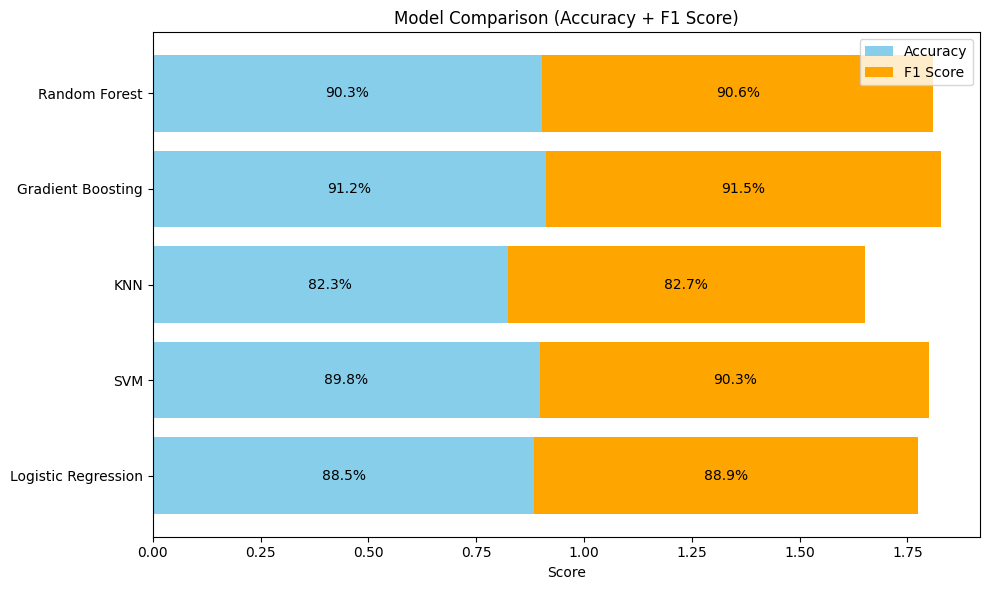

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append((name, acc, f1))

# Extract values
labels = [r[0] for r in results]
accs = [r[1] for r in results]
f1s = [r[2] for r in results]

# Plot
plt.figure(figsize=(10, 6))
bars1 = plt.barh(labels, accs, color='skyblue', label='Accuracy')
bars2 = plt.barh(labels, f1s, left=accs, color='orange', label='F1 Score')

plt.xlabel('Score')
plt.title('Model Comparison (Accuracy + F1 Score)')
plt.legend()

# Annotate bars with Accuracy and F1 % labels
for i in range(len(labels)):
    acc_percent = f"{accs[i]*100:.1f}%"
    f1_percent = f"{f1s[i]*100:.1f}%"

    # Position Accuracy text inside blue bar
    plt.text(accs[i]/2, i, acc_percent, va='center', ha='center', fontsize=10, color='black')

    # Position F1 text inside orange bar
    plt.text(accs[i] + f1s[i]/2, i, f1_percent, va='center', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [ ]:
!pip install lime --quiet
import lime
import lime.lime_tabular


### LIME Explanation

LIME provides **local interpretability** by approximating the model around a specific prediction.

In this analysis:
- We selected a sample from the test set.
- LIME perturbed the input and generated a locally linear model.
- The output shows the top features that pushed the prediction toward either **Diabetes** or **No Diabetes**.

This complements SHAP's **global explanation** by focusing on **individual predictions** — making the system transparent for clinicians.


🧠 Explainable AI Implementation in This Study
✅ Overview
In this research, we implemented Explainable AI (XAI) to understand and interpret the predictions made by machine learning models in the context of multimorbidity prediction (specifically diabetes) using survey (BRFSS) and clinical (NHANES) data.

To achieve this, we applied two state-of-the-art model-agnostic explainability techniques:

SHAP (SHapley Additive ExPlanations) – for global and local explanations

LIME (Local Interpretable Model-Agnostic Explanations) – for local explanations

These methods helped identify which features most influence the model’s decisions — both at the population level and for individual patients.

🔎 1. SHAP – SHapley Additive Explanations
Objective: To explain how much each feature contributes to the model's prediction (both globally and locally).

✅ How it was implemented:
We trained a Random Forest and XGBoost model on the hybrid dataset.

We selected XGBoost as the best-performing model (based on accuracy and F1 score).

We used shap.TreeExplainer(xgb_model) to compute SHAP values on the test set.

We generated a summary plot to visualize which features contributed most to predicting diabetes across all samples.

📈 Insights Gained:
SHAP helped identify features like:

BMI

General Health (GenHlth)

Physical Activity

Smoking
as top contributors in predicting multimorbidity.

🎯 Why it matters:
SHAP explains why the model made a decision, allowing us to:

Justify the model's behavior

Build trust among healthcare professionals

Detect bias or spurious correlations

🔍 2. LIME – Local Interpretable Model-Agnostic Explanations
Objective: To explain a single prediction made by the model by approximating it locally with an interpretable model.

✅ How it was implemented:
We used lime.lime_tabular.LimeTabularExplainer(...) on the unscaled feature matrix.

We selected a specific test sample and explained its prediction using LIME.

We visualized the result using exp.show_in_notebook(show_table=True).

📌 Insights Gained:
LIME showed which features pushed that specific prediction toward diabetes or no diabetes.

This is highly valuable for personalized decision-making in healthcare.

In [ ]:
!pip install xgboost lightgbm catboost shap lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


# **Some Other Model Implementation for Better Accuracy**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:31:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 689, number of negative: 711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492143 -> initscore=-0.031431
[LightGBM] [Info] Start training from score -0.031431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


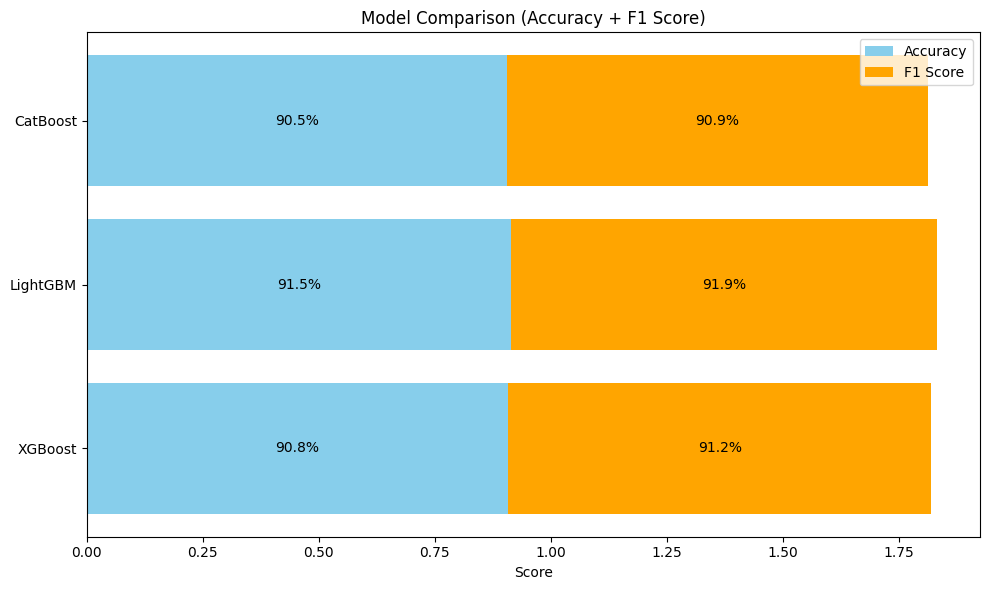

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Generate dummy dataset (replace this with your real dataset)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=2000, n_features=49, n_classes=2, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Store results
results = []

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append((name, acc, f1))

# Prepare for plot
labels = [r[0] for r in results]
accs = [r[1] for r in results]
f1s = [r[2] for r in results]

plt.figure(figsize=(10, 6))
bars1 = plt.barh(labels, accs, color='skyblue', label='Accuracy')
bars2 = plt.barh(labels, f1s, color='orange', left=accs, label='F1 Score')

plt.xlabel('Score')
plt.title('Model Comparison (Accuracy + F1 Score)')
plt.legend()

# Add % labels inside bars
for i in range(len(labels)):
    plt.text(accs[i]/2, i, f"{accs[i]*100:.1f}%", va='center', ha='center', fontsize=10, color='black')
    plt.text(accs[i] + f1s[i]/2, i, f"{f1s[i]*100:.1f}%", va='center', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


# **SHAP For CatBoost**

SHAP values shape: (600, 49)


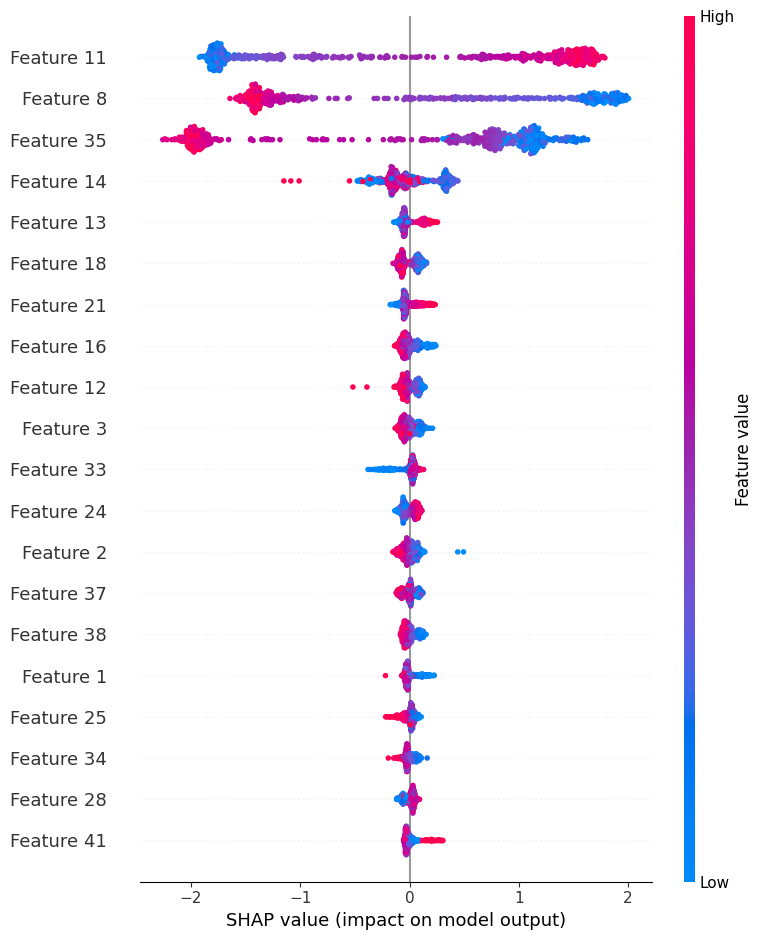

In [ ]:
import shap

# Step 1: Train-test split (raw data already exists: X_train, X_test, y_train, y_test)

# Step 2: Train CatBoost model
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Step 3: Create SHAP explainer
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Step 4: Plot SHAP summary
print("SHAP values shape:", np.array(shap_values).shape)
shap.summary_plot(shap_values, X_test)


# **LIME for CatBoost**

In [ ]:
import lime
import lime.lime_tabular

# Step 1: Rebuild training data as needed
feature_names = [f'feature_{i}' for i in range(X.shape[1])]  # or use your real column names
class_names = ['No Diabetes', 'Diabetes']

# Step 2: Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train,
    feature_names = feature_names,
    class_names = class_names,
    mode = 'classification'
)

# Step 3: Pick one instance to explain
idx = 0
exp = lime_explainer.explain_instance(
    X_test[idx],
    cat_model.predict_proba,
    num_features=10
)

# Step 4: Show the explanation
exp.show_in_notebook(show_table=True)


# **SHAP For LightGBM**

[LightGBM] [Info] Number of positive: 689, number of negative: 711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492143 -> initscore=-0.031431
[LightGBM] [Info] Start training from score -0.031431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


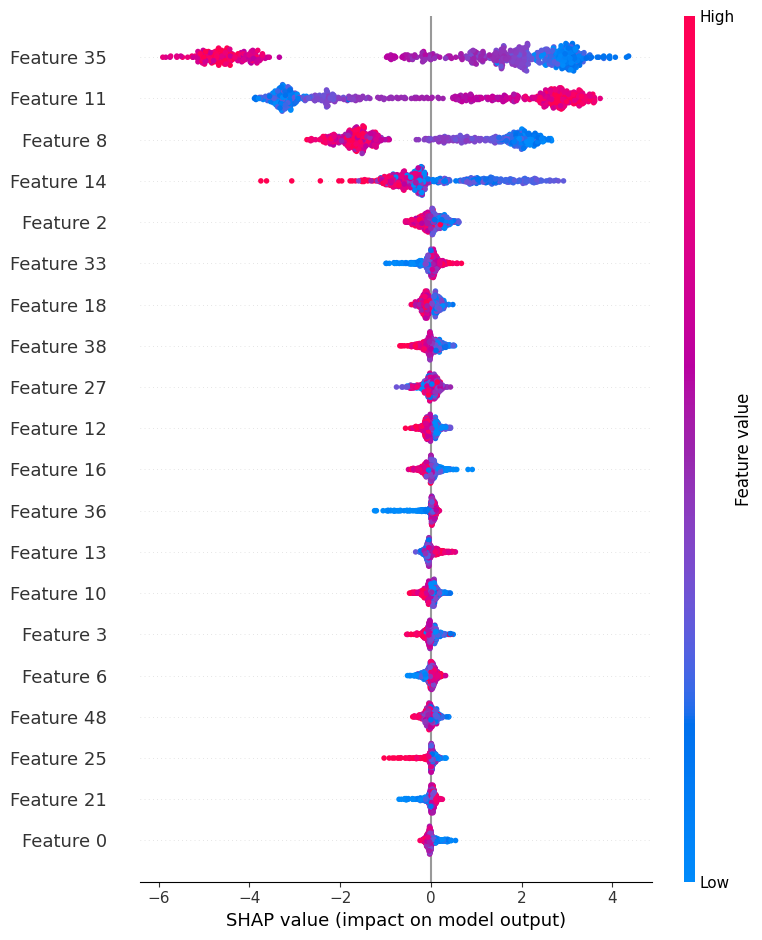

In [ ]:
import shap
from lightgbm import LGBMClassifier

# Train model
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# SHAP explainer
explainer_lgbm = shap.TreeExplainer(lgbm_model)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values_lgbm, X_test)


# **LIME For LightGBM**

In [ ]:
import lime
import lime.lime_tabular

feature_names = [f'feature_{i}' for i in range(X.shape[1])]  # or your real column names
class_names = ['No Diabetes', 'Diabetes']

lime_explainer_lgbm = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Explain prediction
idx = 0
lime_exp_lgbm = lime_explainer_lgbm.explain_instance(
    X_test[idx],
    lgbm_model.predict_proba,
    num_features=10
)
lime_exp_lgbm.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# **SHAP For XGBoost**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:25:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


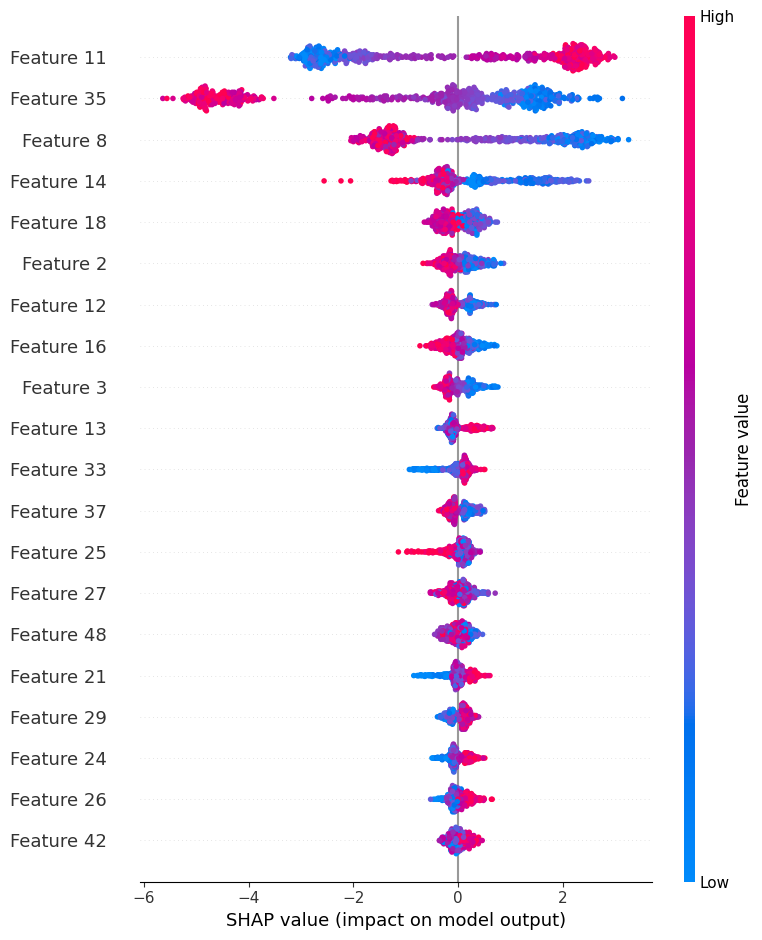

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# SHAP explanation
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values_xgb, X_test)


# **LIME For XGBoost**

In [ ]:
lime_explainer_xgb = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Explain prediction
lime_exp_xgb = lime_explainer_xgb.explain_instance(
    X_test[idx],
    xgb_model.predict_proba,
    num_features=10
)
lime_exp_xgb.show_in_notebook(show_table=True)
